$$\text{Original: }\frac{{dP}}{{dt}} = r_P \cdot P(t) \cdot \left(1 - \frac{{P(t)}}{{K_P}}\right) \cdot \left(\frac{{F(t)}}{{K_F}}\right) - d_P \cdot P(t)$$

$${{N^{(t+1)}}} = {{N^{(t)}}} + r\cdot {{N^{(t)}}} (1-\frac{{N^{(t)}}}{{P}})$$

$${{N^{(t+1)}}} = {{N^{(t)}}} + r\cdot {{N^{(t)}}} (1-\frac{{N^{(t)}}}{{P}})- d\cdot N$$

$$K_i^{(t+1)} = \max \left(\min \left(K_i^*,K_i^t + k(K_i^*-K_i^t)-u_i^t\right),0\right)$$

$$P_i = \sum_{i} K_i$$

$$K^t = \sum_{i=1}^{M} u_i^t K_i^t$$


$$
u_i^t = \begin{cases}
1, & \text{if rank}(K_i^t) \leq P^t \\
0, & \text{otherwise}
\end{cases}
$$


In [1]:
import numpy as np
import random
import powerlaw
import matplotlib.pyplot as plt 
import matplotlib.animation as animation
import warnings
warnings.filterwarnings("ignore")
import ipywidgets as widgets
from IPython.display import display, HTML
from IPython.display import clear_output
import matplotlib.pyplot as plt
import ipywidgets as widgets
from PIL import Image, ImageDraw
%pip install -upgrade ipywidgets
clear_output()
#update


### Land Division Situation - One land, one person

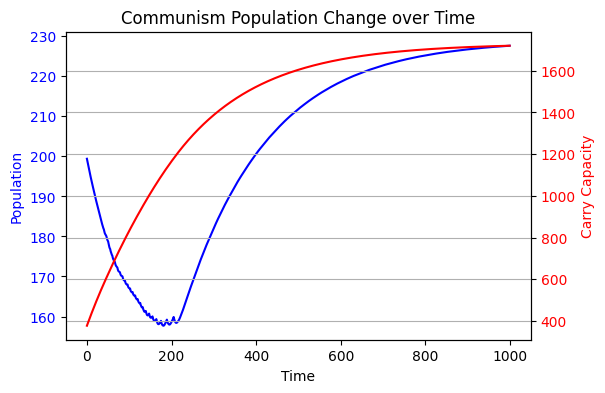

In [2]:
# everyone has the same farming capacity. It doesn't matter who farms.
def communism_simulation_population_original(r, k, d, a, initial_population, simulation_time, max_capacity_one_land):
    ### d is natural death rate
    def carry_capacity(max_capacity_one_land):
        num_lst = np.arange(1, max_capacity_one_land + 1)
        x_min = 1
        alpha = 2
        x = np.linspace(x_min, 5, max_capacity_one_land)
        probabilities = (alpha * x_min**alpha) / (x**(alpha + 1))
        num = random.choices(num_lst, weights=probabilities, k=1)
        return num[0]
    
    populations = [initial_population]  # store population values over time
    P_values = [[0] * initial_population for _ in range(simulation_time)] # total harvest/capacity a year in the village
    u_values = [[0] * initial_population for _ in range(simulation_time)] # using land or not decision
    L_values = [carry_capacity(max_capacity_one_land) for _ in range (initial_population + 1)]
    K_values = [] # land carry capacity  
    Q_values = []

    land_assignments = {} 
    land_assignments[0] = {} # setting ownership: assigning land capacity to each farmer in the zero year
    for i in range(initial_population): 
                land_assignments[0][i+1] = {
                    'landlord': i+1,
                    'land_number': i+1, #land numbering
                    'carry_capacity': L_values[i],
                    'usage': None
                }

    K_t = [land_assignments[0][i]['carry_capacity'] for i in range(1, initial_population + 1)] 
    ### Farming Process
        ### Define the function
    def find_top_lands(K_t, populations): 
        sorted_lands = sorted(enumerate(K_t), key=lambda x: x[1], reverse=True)
        cumulative_utility = 0
        selected_lands = []
                
        for land_index, utility in sorted_lands:
            cumulative_utility += utility
            selected_lands.append(land_index + 1)  # Adding 1 to land_index to represent land number
            if cumulative_utility >= populations[-1]:
                break

        if len(selected_lands) > populations[-1]:
            selected_lands = selected_lands[:len(populations)]
        else: pass
        return selected_lands
   
    ### Updating process
        
    for t in range(1, simulation_time + 1): 
        K_t = [land_assignments[t-1][i]['carry_capacity'] for i in range(1, initial_population + 1)] #from the land_assignment dict, get all the land capacities in the looping year.
        selected_lands = find_top_lands(K_t, populations) # select top lands in each year
        land_assignments[t] = {} # adding a sub-dict in each year, an old one.
        for i in range(initial_population): 
                land_assignments[t][i+1] = {
                    'landlord': i+1,
                    'land_number': i+1, #land numbering
                    'carry_capacity': None,
                    'usage': None
                }

        for i in range(len(land_assignments[t])): #update the dictionary for land usage: "usage"
            if land_assignments[t][i+1]['land_number'] in selected_lands:
                land_assignments[t][i+1]['usage'] = 1
            else:
                land_assignments[t][i+1]['usage'] = 0        

        
        N_t = populations[-1]  # Get the population value at the previous time step. For the first year, it's the initial_population variable.
        u_t = [land_assignments[t][i]['usage'] for i in range (1, initial_population + 1)] # get to use the land or not binary value u
        
        K_t_sum = sum(K_t) # the land carry capacity of the whole village
        P = sum([a*b for a,b in zip(K_t, u_t)]) # the harvest capacity of the whole village. Only consider the selected lands (aka, the top lands).
        if N_t / P > 2: Q = 2 # Q is a factor to slow down the population death rate
        elif N_t / P < 0.5: Q = 0.5
        else: Q = N_t / P
        N_t_plus_1 = N_t + r * N_t * (1 - N_t / P) - d * N_t * Q #### update the total population # the total population of the new year (this year is the new year)
        K_star_t = max_capacity_one_land # the upper limit of each land cell capacity

    #         updating land capacity
        for i in range(1, initial_population + 1):
            land_assignments[t][i]['carry_capacity'] = max(0, min(K_star_t, land_assignments[t-1][i]['carry_capacity'] + k * (K_star_t - land_assignments[t-1][i]['carry_capacity'])  - a * u_t[i-1]))
            if  min(K_star_t, land_assignments[t-1][i]['carry_capacity'] + k * (K_star_t - land_assignments[t-1][i]['carry_capacity'])  - a * u_t[i-1]) == K_star_t:
                print('Cap reached')
        K_t_plus_1 = [land_assignments[t][i]['carry_capacity'] for i in range(1, initial_population + 1)] ## list of each land cell capacity (new year, this year)

        # Append the new values to the respective lists
        populations.append(N_t_plus_1)
        K_values.append(sum(K_t_plus_1)) # total land capacity
        P_values[t-1] = P # update the total harvest capacity
        u_values[t-1] = u_t # update the land usage (Y/N)
        Q_values.append(Q)

    populations = populations[1:] # exclude the zero year population 

    return populations, K_values, P_values, u_values, Q_values, land_assignments

def plot_commuism_simulation_population2(r, k, a, d, initial_population, simulation_time, max_capacity_one_land):
    
    populations, K, _, _, _, data = communism_simulation_population_original(r, k, d, a, initial_population, simulation_time, max_capacity_one_land)
    time_steps = range(simulation_time)

    fig, ax1 = plt.subplots(figsize=(6, 4))

    # Plot population on the first y-axis
    ax1.plot(time_steps, populations, color='blue', label='Population')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Population', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Create a secondary y-axis and plot carry capacity on it
    ax2 = ax1.twinx()
    ax2.plot(time_steps, K, color='red', label='Carry Capacity')
    ax2.set_ylabel('Carry Capacity', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    plt.grid()
    plt.title('Communism Population Change over Time')
    plt.show()


r = 0.135 # population birth rate
k = 0.005 # land recovery rate 
a = 0.05 # land deplation rate
d = 0.003
simulation_time = 1000 #simulation year
initial_population = 200
max_capacity_one_land = 10
plot_commuism_simulation_population2(r, k, a, d, initial_population, simulation_time, max_capacity_one_land)

### Land Capacity Animation - Please do not run here.

In [ ]:


# Your simulation data
populations, K, _, _, _, data = communism_simulation_population_original(r, k, d, a, initial_population, simulation_time, max_capacity_one_land)

# Define the dimension of the grid
grid_dim = int(np.sqrt(max(data[0].keys())))

# Create a colormap
cmap = plt.get_cmap('RdYlBu')

# Function to render the animation for a given year
def render_animation(year):
    # Get the data for the current year
    year_data = data.get(year, {})

    # Create an image with a white background
    image = Image.new('RGBA', (grid_dim * 100, grid_dim * 100), color=(255, 255, 255, 0))
    draw = ImageDraw.Draw(image)

    if year_data:
        # Iterate over each land cell for the current year
        for land_number, land_data in sorted(year_data.items()):
            carry_capacity = land_data.get('carry_capacity', 0)
            # Map the carry_capacity to a color
            color = cmap(carry_capacity / max_capacity_one_land)

            # Calculate the position of the land cell
            x = (land_number % grid_dim) * 100
            y = (land_number // grid_dim) * 100

            # Draw a rectangle representing the land cell
            draw.rectangle([(x, y), (x + 100, y + 100)], fill=(int(color[0] * 255), int(color[1] * 255), int(color[2] * 255)))

            # Add the carry capacity as text
            draw.text((x + 10, y + 30), f'{carry_capacity}', fill='black')

    return image

# Create a list to store the animation frames
animation_frames = []

# Iterate over each year and generate frames
for year in range(max(data.keys()) + 1):
    image = render_animation(year)
    animation_frames.append(image)
    
animation_frames[0].save('animation.gif', format='GIF', append_images=animation_frames[1:], save_all=True, duration=200, loop=0, optimize=True)
display(widgets.Image(value=open('animation.gif', 'rb').read()))


### Sensitivity - Parameter Analysis - Population

In [3]:

r_range = [0.01, 0.04, 0.07, 0.1]
k_range = [0.001, 0.01, 0.02, 0.03]
d_range = [0.0005, 0.001, 0.003, 0.005]
a_range = [0.01, 0.04, 0.06, 0.1]
c_range = [5, 15, 30, 50]

baseline_r = 0.04  # Select a baseline value for r
baseline_k = 0.01  # Select a baseline value for k
baseline_d = 0.001  # Select a baseline value for d
baseline_a = 0.04  # Select a baseline value for a
baseline_c = 15  # Select a baseline value for c

# Vary r while keeping other parameters constant ##
r_result_pop = []
r_result_food = []
for r in r_range:
    result, cap, _, _, _, _ = communism_simulation_population_original(r, baseline_k, baseline_d, baseline_a, initial_population, simulation_time, baseline_c)
    print("r =", r, "Result =", result)
    r_result_pop.append(result)
    r_result_food.append(cap)
# Vary k while keeping other parameters constant
k_result_pop = []
k_result_food = []
for k in k_range:
    result, cap, _, _, _, _ = communism_simulation_population_original(baseline_r, k, baseline_d, baseline_a, initial_population, simulation_time, baseline_c)
    print("k =", k, "Result =", result)
    k_result_pop.append(result)
    k_result_food.append(cap)
# Vary d while keeping other parameters constant
d_result_pop = []
d_result_food = []
for d in d_range:
    result, cap, _, _, _, _ = communism_simulation_population_original(baseline_r, baseline_k, d, baseline_a, initial_population, simulation_time, baseline_c)
    print("d =", d, "Result =", result)
    d_result_pop.append(result)
    d_result_food.append(cap)

# Vary a while keeping other parameters constant
a_result_pop = []
a_result_food = []
for a in a_range:
    result, cap, _, _, _, _ = communism_simulation_population_original(baseline_r, baseline_k, baseline_d, a, initial_population, simulation_time, baseline_c)
    print("a =", a, "Result =", result)
    a_result_pop.append(result)
    a_result_food.append(cap)
# Vary c while keeping other parameters constant
c_result_pop = []
c_result_food = []
for c in c_range:
    result, cap, _, _, _, _ = communism_simulation_population_original(baseline_r, baseline_k, baseline_d, initial_population, simulation_time, baseline_a, c)
    print("c =", c, "Result =", result)
    c_result_pop.append(result)
    c_result_food.append(cap)



r = 0.01 Result = [199.83251231527092, 199.6750494390098, 199.52732664447862, 199.38906923473525, 199.19416572771, 199.00945612226982, 198.83465162516495, 198.66866604619256, 198.51204618376914, 198.36453606013208, 198.22588846440658, 198.09586056373504, 197.90311480485238, 197.71985278111433, 197.54581983203965, 197.3800247828649, 197.2225961134047, 197.0736873169272, 196.93271274462904, 196.79911095551944, 196.6733713185967, 196.4797919938535, 196.29399512990108, 196.116834912004, 195.94706251067205, 195.78514322495266, 195.63089573899924, 195.48345063517496, 195.34360596751716, 195.2102283437239, 195.08416425664103, 194.96480468125174, 194.77112206984296, 194.58462523763203, 194.40569956623327, 194.23434032352196, 194.0697232519456, 193.91220324158388, 193.76152889037738, 193.6171720102787, 193.4794844414505, 193.34800273321846, 193.22242936636968, 193.10313809686522, 192.9894751147539, 192.8813350802055, 192.68988139334186, 192.5053981929352, 192.32795348289315, 192.1570012319623, 

TypeError: 'float' object cannot be interpreted as an integer

 Question: Why there it's a check shape?

Parameter analysis:  
Sensitivity analysis  
Variance-based methods  
Parameter estimation techniques  
Optimization algorithms  